# model 3rd: ノンパラメトリック回帰をhiking functionでおこなう

In [15]:
import os
import polars as pl
import polars
import numpy as np
import matplotlib.pyplot as plt
import pyvisgraph as vg

import pickle

import geopandas as gpd
from shapely import unary_union, wkt

from tqdm import tqdm

In [ ]:
def create_grid_visualization(df):
    # グリッドの次元を取得
    x_max = df['grid_x'].max() + 1
    y_max = df['grid_y'].max() + 1
    
    # 2D配列に変換
    grid = np.zeros((y_max, x_max))
    for row in df.iter_rows():
        x, y, cost = row
        grid[y, x] = cost
    
    # プロットの作成
    plt.figure(figsize=(12, 8))
    
    # pcolormeshでヒートマップを描画
    im = plt.pcolormesh(grid, cmap='viridis', shading='auto')
    
    # カラーバーを追加
    
    plt.colorbar(im, label='Cost')
    
    # 軸ラベルを設定
    plt.xlabel('Grid X')
    plt.ylabel('Grid Y')
    plt.title('Cost Distribution Heatmap')
    
    # グリッドを表示
    plt.grid(True)
    
    return plt

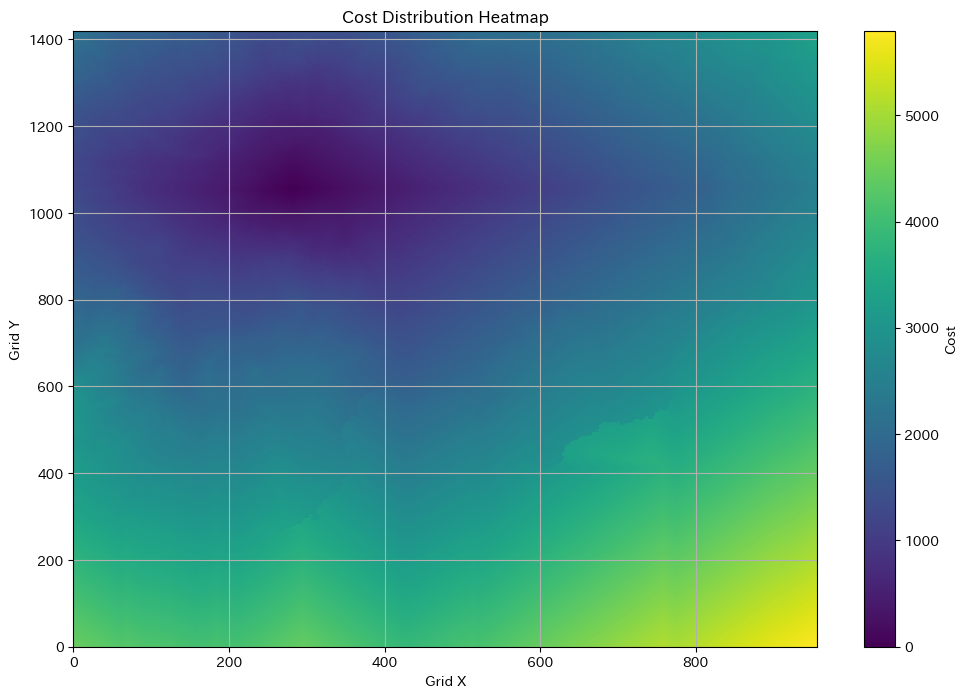

In [45]:
data_dir = "/home/ohta/dev/bayesian_statistics/data/"
i = 10

### pickleで保存したファイルを読み込み
with open(os.path.join(data_dir, "16_tobler_distance_with_coast", f"distance_siteID_{i}"), mode='br') as fi:
  min_costs = pickle.load(fi)

width = 956
height = 1420

# grid_x, grid_y, min_cost_minutsという列を持つpl.DataFrameを作成
min_costs_df = pl.DataFrame({
    "grid_x": np.tile(np.arange(width), height),
    "grid_y": np.repeat(np.arange(height), width),
    f"cost_{i}": min_costs
})

# 使用例:
plt_ = create_grid_visualization(min_costs_df)
plt_.show()

### 説明変数を入れてカーネル回帰とIPPを同時推定

In [18]:
import os
from typing import Tuple
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import japanize_matplotlib

In [19]:
# 地点ごとの産地構成比を計算

def preprocess_data(
    df: pl.DataFrame,
    target_period: int,
    target_origin: str
) -> Tuple[np.ndarray, np.ndarray]:
    """
    解析用のデータを前処理
    
    Parameters
    ----------
    df : pl.DataFrame
        入力データフレーム
    target_period : int
        対象時期
    target_origin : str
        対象産地カテゴリ
        
    Returns
    -------
    counts : np.ndarray
        各遺跡での出土数（インデックスが遺跡ID）
    target_counts : np.ndarray
        対象産地の出土数（インデックスが遺跡ID）
    """
    # 全遺跡IDのリストを取得
    max_site_id = df['遺跡ID'].max()
    
    # 対象時期のデータのみ抽出
    period_df = df.filter(pl.col('時期') == target_period)
    
    # 全体のカウント
    counts = (
        period_df
        .group_by('遺跡ID')
        .agg([pl.len().alias('count')])
        .join(
            pl.DataFrame({
                '遺跡ID': np.arange(max_site_id + 1)
            }),
            on='遺跡ID',
            how='right'
        )
        .fill_null(0)
        .sort('遺跡ID')['count']
        .to_numpy()
    )
    
    # 対象産地のカウント
    target_counts = (
        period_df
        .filter(pl.col('産地カテゴリ') == target_origin)
        .group_by('遺跡ID')
        .agg([pl.len().alias('count')])
        .join(
            pl.DataFrame({
                '遺跡ID': np.arange(max_site_id + 1)
            }),
            on='遺跡ID',
            how='right'
        )
        .fill_null(0)
        .sort('遺跡ID')['count']
        .to_numpy()
    )
    
    return counts, target_counts


In [20]:
def create_site_coords(df: pl.DataFrame) -> np.ndarray:
    """
    遺跡の座標をラジアンに変換
    
    Parameters
    ----------
    df : pl.DataFrame
        入力データフレーム
        
    Returns
    -------
    np.ndarray
        遺跡の座標（ラジアン）
    """
    # 座標をラジアンに変換
    coords = (
        df
        .select([
            (pl.col("遺跡ID")), 
            (pl.col('緯度') * np.pi / 180).alias('lat_rad'),
            (pl.col('経度') * np.pi / 180).alias('lon_rad')
        ])
        .unique(subset=["遺跡ID"])
        .sort("遺跡ID")
    )
    
    # 座標と出土数を numpy 配列に変換
    site_coords = np.column_stack([
        coords['lat_rad'].to_numpy(),
        coords['lon_rad'].to_numpy()
    ])

    return site_coords

In [21]:
def get_site_grid_coords(df_obsidian: pl.DataFrame, df_elevation: pl.DataFrame) -> np.ndarray:
    """
    遺跡の座標をグリッド座標に変換
    
    Parameters
    ----------
    df_obsidian : pl.DataFrame
        遺跡のデータフレーム
    df_elevation : pl.DataFrame
        標高のデータフレーム
        
    Returns
    -------
    np.ndarray
        遺跡のグリッド座標
    """

    x_spacing = df_elevation["x"].unique().sort().diff().mode()[0]
    y_spacing = df_elevation["y"].unique().sort().diff().mode()[0]
    x_first_center = df_elevation["x"].min()
    y_first_center = df_elevation["y"].min()

    coords = (
            df_obsidian
            .select([
                (pl.col("遺跡ID")), 
                (pl.col('緯度')),
                (pl.col('経度'))
            ])
            .unique(subset=["遺跡ID"])
            .sort("遺跡ID")
            .with_columns([
                ((pl.col('経度') - (x_first_center - (x_spacing / 2))) / x_spacing).cast(pl.Int64).alias("grid_x"),
                ((pl.col('緯度') - (y_first_center - (y_spacing / 2))) / y_spacing).cast(pl.Int64).alias("grid_y")
            ])
        )

    site_grid_coords = np.column_stack([
            coords['grid_x'].to_numpy(),
            coords['grid_y'].to_numpy()
        ])

    return site_grid_coords

In [22]:
# 重みの初期計算
def K(x, sigma):
    return np.exp(-0.5 * (x**2) / (sigma**2)) / (2 * np.pi * sigma**2)

def calculate_weights_matrix(
    grid_coords: np.ndarray, #(グリッド数, 2)
    site_coords: np.ndarray, #(遺跡数, 2)
    sigma: float,
) -> np.ndarray: # (グリッド数, 遺跡数)
    """
    重み行列を計算
    """
    R = 6371  # 地球の半径(km)
    
    # 通常の距離計算
    dlat = grid_coords[:, np.newaxis, 0] - site_coords[np.newaxis, :, 0]
    dlon = grid_coords[:, np.newaxis, 1] - site_coords[np.newaxis, :, 1]
    
    a = (np.sin(dlat/2)**2 + 
         np.cos(grid_coords[:, np.newaxis, 0]) * 
         np.cos(site_coords[np.newaxis, :, 0]) * 
         np.sin(dlon/2)**2)
    
    distances = 2 * R * np.arcsin(np.sqrt(a))
    
    weights = K(distances, sigma)

    return weights

In [23]:
def calculate_distance_W(
    W_grid: np.ndarray,
    W_sites: np.ndarray,
) -> np.ndarray:
    """
    説明変数間の距離行列を計算

    Parameters
    ----------
    W_grid : np.ndarray
        グリッドの説明変数 (グリッド数, p)
    W_sites : np.ndarray
        遺跡の説明変数 (遺跡数, p)

    p は説明変数の次元数

    Returns
    -------
    np.ndarray
        説明変数間の距離行列 (グリッド数, 遺跡数, p)
    """
    # W_gridを(グリッド数, 1, p)に、W_sitesを(1, 遺跡数, p)に reshape
    # ブロードキャストにより自動的に(グリッド数, 遺跡数, p)に拡張される
    W_grid_expanded = W_grid[:, np.newaxis, :]
    W_sites_expanded = W_sites[np.newaxis, :, :]
    
    # ユークリッド距離の計算
    distances = np.abs(W_grid_expanded - W_sites_expanded)
    
    return distances

In [24]:
def create_land_mask(grid_coords, df_elevation, lon_mesh, lat_mesh):
    # 地形マスクの作成
    land_points = df_elevation.select([
        'x',
        'y',
        pl.col('is_sea').cast(pl.Boolean)
    ]).to_numpy()
    
    lons_1d = lon_mesh[0, :]
    lats_1d = lat_mesh[:, 0]
    land_mask = np.full(lon_mesh.shape, False)
    
    x_indices = np.searchsorted(lons_1d, land_points[:, 0])
    y_indices = np.searchsorted(lats_1d, land_points[:, 1])
    valid_points = (
        (x_indices > 0) & 
        (x_indices < len(lons_1d)) & 
        (y_indices > 0) & 
        (y_indices < len(lats_1d))
    )
    is_sea = land_points[valid_points, 2].astype(bool)
    land_mask[y_indices[valid_points], x_indices[valid_points]] = ~is_sea
    
    # grid_coordsの各点について、対応するland_maskの値を取得
    grid_lons = grid_coords[:, 1] * 180/np.pi  # ラジアンから度に変換
    grid_lats = grid_coords[:, 0] * 180/np.pi
    
    grid_x_indices = np.searchsorted(lons_1d, grid_lons)
    grid_y_indices = np.searchsorted(lats_1d, grid_lats)
    
    # インデックスが有効範囲内にあることを確認
    valid_grid_points = (
        (grid_x_indices > 0) & 
        (grid_x_indices < len(lons_1d)) & 
        (grid_y_indices > 0) & 
        (grid_y_indices < len(lats_1d))
    )
    
    # 海上の点の重みを0に設定
    grid_is_land = np.zeros(len(grid_coords), dtype=bool)
    grid_is_land[valid_grid_points] = land_mask[
        grid_y_indices[valid_grid_points],
        grid_x_indices[valid_grid_points]
    ]

    return grid_is_land

In [25]:
def calculate_ratios(
    weights: np.ndarray,
    counts: np.ndarray,
    target_counts: np.ndarray
) -> np.ndarray:
    """
    重み付き比率を計算
    
    Parameters
    ----------
    weights : np.ndarray
        重み行列
    counts : np.ndarray
        各遺跡での出土数
    target_counts : np.ndarray
        対象産地の出土数
        
    Returns
    -------
    ratios : np.ndarray
        各グリッド点での重み付き比率
    """
    # 重み付き合計を計算
    weighted_total = np.sum(weights * counts, axis=1)
    weighted_target = np.sum(weights * target_counts, axis=1)
    
    # 比率計算（0除算を防ぐ）
    ratios = np.where(
        weighted_total > 0,
        weighted_target / weighted_total,
        0
    )
    
    return ratios

In [26]:
def plot_contour(df, x_col='x', y_col='y', value_col='cost_kouzu', figsize=(12, 8), plot_probability=False, n_levels=30):

    import japanize_matplotlib

    # まず海陸判定のマスクを作成
    mask = (
        df
        .with_columns(
            (~pl.col('is_sea')).alias("is_not_sea")
        )
        .pivot(
            values='is_not_sea',
            on=x_col,
            index=y_col
        )
    )

    # 値のピボットテーブルを作成
    grid_data = (
        df
        .pivot(
            values=value_col,
            on=x_col,
            index=y_col
        )
    )

    # マスクを適用（y_col列は保持）
    grid_data = grid_data.with_columns(
        [
            pl.col(col) * mask.get_column(col)
            for col in grid_data.columns
            if col != y_col
        ]
    )
    
    # メッシュグリッドの作成
    x_mesh = np.array(grid_data.columns[1:], dtype=float)
    y_mesh = np.array(grid_data.to_numpy()[:, 0], dtype=float)
    values_mesh = grid_data.to_numpy()[:, 1:]
    
    # プロット作成
    fig, ax = plt.subplots(figsize=figsize)
    
    if plot_probability:
        # 確率表示モード（0-1の範囲）
        contour = ax.contourf(
            x_mesh, y_mesh, values_mesh,
            levels=np.linspace(0, 1, n_levels + 1),
            cmap='Blues',
            alpha=0.7,
            vmin=0,
            vmax=1
        )
    else:
        # 通常モード（データをそのまま使用）
        contour = ax.contourf(
            x_mesh, y_mesh, values_mesh, 
            levels=n_levels, 
            cmap='Blues',
            alpha=0.7
        )
    
    # カラーバーの追加
    if plot_probability:
        # カラーバー（0-1の範囲に固定）
        plt.colorbar(contour, ax=ax, label='Ratio', ticks=np.linspace(0, 1, 6))
    else:
        plt.colorbar(contour, ax=ax)
    
    # ラベルの設定
    ax.set_xlabel('経度')
    ax.set_ylabel('緯度')
    
    return fig, ax

In [27]:
SCHEMA = pl.Schema({
    'grid_x': pl.Int64,
    'x': pl.Float64,
    'grid_y': pl.Int64,
    'y': pl.Float64,
    'mesh_code_5th': pl.Int64,
    'average_elevation': pl.Float64,
    'maximum_elevation': pl.Float64,
    'minimum_elevation': pl.Float64,
    'minimum_elevation_code': pl.Int64,
    'maximum_slope_angle': pl.Float64,
    'maximum_slope_direction': pl.Int64,
    'minimum_slope_angle': pl.Float64,
    'minimum_slope_direction': pl.Int64,
    'average_slope_angle': pl.Float64,
    'geometry': pl.Utf8,
    'is_sea': pl.Boolean,
    'walking_velocity': pl.Float64,
    'travel_time': pl.Float64,
    'elevation_diff_east': pl.Float64,
    'angle_east': pl.Float64,
    'walking_velocity_east': pl.Float64,
    'travel_time_east': pl.Float64,
    'elevation_diff_west': pl.Float64,
    'angle_west': pl.Float64,
    'walking_velocity_west': pl.Float64,
    'travel_time_west': pl.Float64,
    'elevation_diff_north': pl.Float64,
    'angle_north': pl.Float64,
    'walking_velocity_north': pl.Float64,
    'travel_time_north': pl.Float64,
    'elevation_diff_south': pl.Float64,
    'angle_south': pl.Float64,
    'walking_velocity_south': pl.Float64,
    'travel_time_south': pl.Float64,
    'cost_kouzu': pl.Float64,
    'cost_shinshu': pl.Float64,
    'cost_hakone': pl.Float64,
    'cost_takahara': pl.Float64,
    'cost_river': pl.Float64,
    'x_meter': pl.Float64,
    'y_meter': pl.Float64
})

In [28]:
data_dir = "/home/ohta/dev/bayesian_statistics/data/"

df_elevation = pl.read_csv(
    os.path.join(data_dir, "11_gdf_elevation.csv"),
    null_values=["nan"]  # "nan"をnullとして扱う
)
df_elevation = (
    # データ型を変換
    df_elevation.cast(SCHEMA)
        # 全く欠損していない行をis_validとする
        .with_columns([
            pl.all_horizontal(
                [
                    ~pl.col(col).is_null()
                    for col in df_elevation.columns
                ]
            )
            .alias('is_valid')
        ])
)

df_obsidian = pl.read_csv(os.path.join(data_dir, "11_gdf_obsidian.csv"))
df_sites = pl.read_csv(os.path.join(data_dir, "11_gdf_sites.csv"))

time_period_name = {
    0: "早期・早々期",
    1: "前期",
    2: "中期",
    3: "後期",
    4: "晩期"
}

origin_order = ["神津島", "信州", "箱根", "高原山", "その他"]

sigma = 500
sigma_for_sites = 0.1

# =======================================================================================

# メッシュグリッドを作成
lon_mesh, lat_mesh = np.meshgrid(
    df_elevation['x'].unique().sort(),  # 経度の一意な値
    df_elevation['y'].unique().sort()   # 緯度の一意な値
)

print(lon_mesh.shape, lat_mesh.shape)

# 遺跡の位置: (遺跡数, 2)
site_coords = create_site_coords(df_obsidian)

# グリッドの位置座標: (グリッド数, 2)
grid_coords = np.column_stack([
    lat_mesh.ravel() * np.pi / 180,
    lon_mesh.ravel() * np.pi / 180
])

(1420, 956) (1420, 956)


In [22]:
df_sites = (
    df_sites
        .join(
            df_elevation.drop(["x", "y"]).with_columns([pl.col("mesh_code_5th").cast(pl.Int64).alias("mesh_code_5th")]),
            left_on="メッシュコード", 
            right_on="mesh_code_5th", 
            how="left"
        )
)

## 説明変数を入れたcoordsを作成する

In [23]:
# 説明変数の一覧
variable_names = [
    'average_elevation', 
    'average_slope_angle', 
    'cost_kouzu',
    'cost_shinshu',
    'cost_hakone',
    'cost_takahara',
    'cost_river'
]

# grid_coordsに対応する形で説明変数を取得: (グリッド数, p)
W_grids = df_elevation.sort(['y', 'x']).select(variable_names).to_numpy().astype(np.float64)

# site_coordsに対応する形で説明変数を取得: (遺跡数, p)
W_sites = df_sites.sort('遺跡ID').select(variable_names).to_numpy().astype(np.float64)

In [24]:
# ====================
# 距離行列を読み込む
# ====================

# 距離行列の読み込み
### pickleで保存したファイルを読み込み

distances = np.zeros((len(grid_coords), len(site_coords)))
for i in range(len(site_coords)):
    with open(os.path.join(data_dir, "16_tobler_distance", f"distance_siteID_{i}"), mode='br') as fi:
        min_costs = pickle.load(fi)
        distances[:, i] = min_costs

In [25]:
# ====================
# 重み行列を計算
# ====================

weights = K(distances, sigma)

In [26]:
print("creating weights matrix...")
# 陸地のみの重み行列の計算
#weights = calculate_weights_matrix(
#    grid_coords, site_coords, sigma
#)

# 説明変数間の距離行列の計算
print("calculating distance_W...")
distance_W = calculate_distance_W(W_grids, W_sites)

weights_W = K(distance_W, sigma).prod(axis=2)

weights *= weights_W

print("updating weights matrix...")

# 重みの更新
grid_is_land = create_land_mask(grid_coords, df_elevation, lon_mesh, lat_mesh)

# 海上の点からの重みをすべて0に
weights *= grid_is_land[:, np.newaxis]

# 遺跡についての計算 ============================================================================
        
# 遺跡の一意な地点を取得
unique_sites = df_obsidian.unique(subset=['遺跡ID']).sort('遺跡ID')

# 計算対象の遺跡の座標をラジアンに変換
target_coords_sites = np.column_stack([
    unique_sites['緯度'].to_numpy() * np.pi / 180,
    unique_sites['経度'].to_numpy() * np.pi / 180
])

creating weights matrix...
calculating distance_W...


updating weights matrix...


In [27]:
# ============================
# sites同士の距離行列を計算
# ============================

site_grid_coords = get_site_grid_coords(df_obsidian, df_elevation)

def idx(x, y):
    return y * width + x

# distancesは(グリッド数, 遺跡数)の形状なので、i=idx(site_grid_coords)として、distances[i]をスライスすれば、(遺跡数, 遺跡数)の形状になる
site_grid_idx = np.vectorize(idx)(site_grid_coords[:, 0], site_grid_coords[:, 1])

distances_sites = distances[site_grid_idx]
weights_sites = K(distances_sites, sigma_for_sites)

In [28]:
ratio_df = pl.DataFrame({
    'x': lon_mesh.ravel(),
    'y': lat_mesh.ravel()
})

ratio_sites_df = pl.DataFrame({
    '遺跡ID': df_sites['遺跡ID']
})

target_period = 0
target_origin = "神津島"

print(f"target_period: {target_period}, target_origin: {target_origin}")

# ここからtarget_period, target_originに依存する処理
counts, target_counts = preprocess_data(
    df_obsidian, target_period, target_origin
)

# 重み付き比率の計算
ratio_mesh = calculate_ratios(weights, counts, target_counts).reshape(lon_mesh.shape)

ratio_df = ratio_df.join(
    pl.DataFrame({
        'x': lon_mesh.ravel(),
        'y': lat_mesh.ravel(),
        f"ratio_{target_period}_{target_origin}": ratio_mesh.ravel()
    }),
    on=["x", "y"]
)

# 比率の計算
ratios = calculate_ratios(weights_sites, counts, target_counts)

ratio_sites_df = ratio_sites_df.join(
    pl.DataFrame({
        '遺跡ID': unique_sites['遺跡ID'],
        f"比率_{target_period}_{target_origin}": ratios
    }),
    on="遺跡ID"
)

df_elevation = df_elevation.join(
    ratio_df,
    on=["x", "y"]
)
df_sites = df_sites.join(
    ratio_sites_df,
    on="遺跡ID"
)

target_period: 0, target_origin: 神津島


/tmp/ipykernel_1602064/2700593529.py:30: RuntimeWarning: invalid value encountered in divide
  weighted_target / weighted_total,


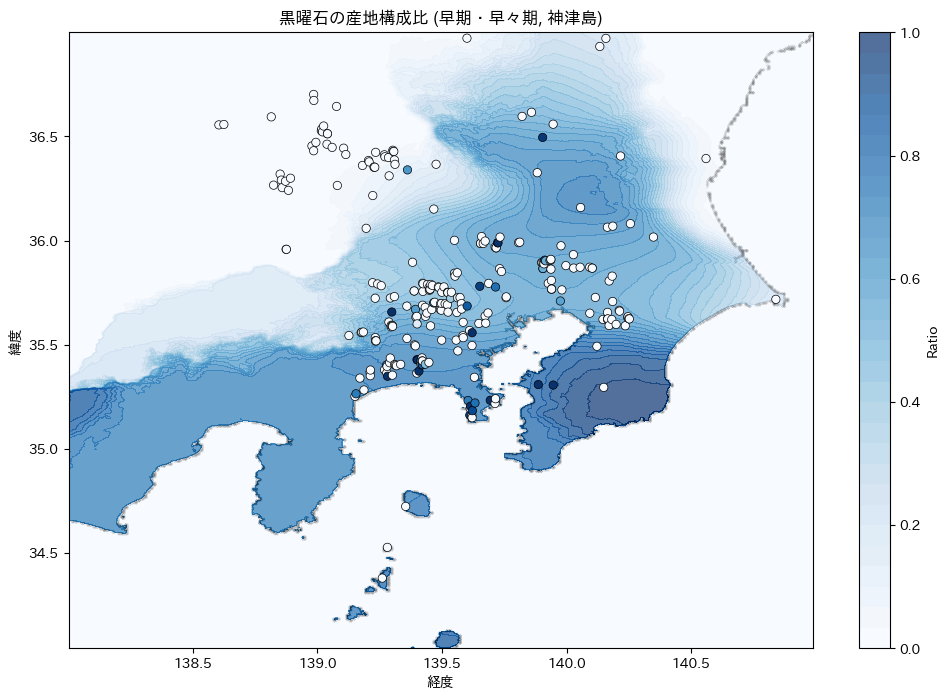

In [29]:
fig, ax = plot_contour(df_elevation, value_col=f"ratio_{target_period}_{target_origin}", plot_probability=True)

boundary_df = df_elevation.filter(pl.col("is_sea") == 0, pl.col("average_elevation").is_null())

ax.scatter(
    boundary_df["x"], 
    boundary_df["y"], 
    c="black", 
    s=0.001
)

ax.scatter(
    df_sites["経度"], 
    df_sites["緯度"], 
    c=df_sites[f"比率_{target_period}_{target_origin}"], 
    cmap="Blues", 
    edgecolors="black", 
    linewidths=0.5,
    vmin=0,
    vmax=1 
)

ax.set_title(f"黒曜石の産地構成比 ({time_period_name[target_period]}, {target_origin})")
plt.show()

## 全時期、全産地について計算

In [30]:


# ============================================================================================

ratio_df = pl.DataFrame({
    'x': lon_mesh.ravel(),
    'y': lat_mesh.ravel()
})

ratio_sites_df = pl.DataFrame({
    '遺跡ID': df_sites['遺跡ID']
})


for target_period in time_period_name.keys():
    for target_origin in origin_order[:-1]:

        print(f"target_period: {target_period}, target_origin: {target_origin}")

        # ここからtarget_period, target_originに依存する処理
        counts, target_counts = preprocess_data(
            df_obsidian, target_period, target_origin
        )

        # 重み付き比率の計算
        ratio_mesh = calculate_ratios(weights, counts, target_counts).reshape(lon_mesh.shape)
        
        ratio_df = ratio_df.join(
            pl.DataFrame({
                'x': lon_mesh.ravel(),
                'y': lat_mesh.ravel(),
                f"ratio_{target_period}_{target_origin}": ratio_mesh.ravel()
            }),
            on=["x", "y"]
        )
        
        # 比率の計算
        ratios = calculate_ratios(weights_sites, counts, target_counts)

        ratio_sites_df = ratio_sites_df.join(
            pl.DataFrame({
                '遺跡ID': unique_sites['遺跡ID'],
                f"比率_{target_period}_{target_origin}": ratios
            }),
            on="遺跡ID"
        )

df_elevation = df_elevation.join(
    ratio_df,
    on=["x", "y"]
)
df_sites = df_sites.join(
    ratio_sites_df,
    on="遺跡ID"
)

# %%
df_elevation.write_csv(os.path.join(data_dir, "16_gdf_elevation_with_ratio.csv"))
df_sites.write_csv(os.path.join(data_dir, "16_gdf_sites_with_ratio.csv"))


target_period: 0, target_origin: 神津島


/tmp/ipykernel_1602064/2700593529.py:30: RuntimeWarning: invalid value encountered in divide
  weighted_target / weighted_total,


target_period: 0, target_origin: 信州
target_period: 0, target_origin: 箱根
target_period: 0, target_origin: 高原山
target_period: 1, target_origin: 神津島
target_period: 1, target_origin: 信州
target_period: 1, target_origin: 箱根
target_period: 1, target_origin: 高原山
target_period: 2, target_origin: 神津島
target_period: 2, target_origin: 信州
target_period: 2, target_origin: 箱根
target_period: 2, target_origin: 高原山
target_period: 3, target_origin: 神津島
target_period: 3, target_origin: 信州
target_period: 3, target_origin: 箱根
target_period: 3, target_origin: 高原山
target_period: 4, target_origin: 神津島
target_period: 4, target_origin: 信州
target_period: 4, target_origin: 箱根
target_period: 4, target_origin: 高原山


### IPP

In [31]:
from bayesian_statistics.utils_2 import *

In [32]:
from typing import Optional, Union

def prepare_grid_info(df_elevation: pl.DataFrame) -> dict:
    """
    df_elevation の x, y が「5次メッシュなどのメッシュ中心座標」である前提で、
    ・最小中心 x_min_center, 最大中心 x_max_center
    ・最小中心 y_min_center, 最大中心 y_max_center
    ・ステップ幅 delta_x, delta_y
    を算出して返す。

    例:
      grid_info = prepare_grid_info_center(df_elevation)
      # => {
      #      "x_min_center": 138.0,
      #      "x_max_center": 141.0,
      #      "y_min_center": 34.0,
      #      "y_max_center": 37.0,
      #      "delta_x": 0.0025,
      #      "delta_y": 0.002083333333,
      #    }
    """
    x_unique = df_elevation.select("x").unique().to_series().to_list()
    y_unique = df_elevation.select("y").unique().to_series().to_list()
    x_unique.sort()
    y_unique.sort()

    if len(x_unique) < 2 or len(y_unique) < 2:
        raise ValueError("x あるいは y のユニーク値が2つ以上ありません。")

    # 隣り合う中心座標の差からステップ幅を算出 (5次メッシュなら等間隔のはず)
    delta_x = x_unique[1] - x_unique[0]
    delta_y = y_unique[1] - y_unique[0]

    return {
        "x_min_center": x_unique[0],
        "x_max_center": x_unique[-1],
        "y_min_center": y_unique[0],
        "y_max_center": y_unique[-1],
        "delta_x": delta_x,
        "delta_y": delta_y
    }


def get_grid_xy(
    x: Union[float, np.ndarray],
    y: Union[float, np.ndarray],
    grid_info: dict,
) -> Union[Optional[tuple[int, int]], np.ndarray]:
    """
    (x, y) が「メッシュの中心座標」をベースに区切られた格子のどこに含まれるかを O(1) で求める。

    - 引数の x, y は スカラー(float) でもよいし、同じ shape の np.ndarray でもよい
    - スカラーの場合:
        範囲内なら (grid_x, grid_y) のタプルを返す。範囲外なら None を返す。
    - 配列の場合:
        shape (N,) などの1次元配列を想定。戻り値は shape (N, 2) の np.ndarray。
        範囲内要素は (gx, gy)、範囲外要素は (-1, -1) を入れる。

    ロジック(中心座標ベース):
      1. メッシュの左境界 = (x_min_center - delta_x / 2), 下境界 = (y_min_center - delta_y / 2)
      2. メッシュの右境界 = (x_max_center + delta_x / 2), 上境界 = (y_max_center + delta_y / 2)
      3. x(または y) が [左境界, 右境界] (または [下境界, 上境界]) にあれば範囲内
      4. 格子番号 = floor((x - 左境界)/delta_x), floor((y - 下境界)/delta_y)
    """
    x_min_c = grid_info["x_min_center"]
    x_max_c = grid_info["x_max_center"]
    y_min_c = grid_info["y_min_center"]
    y_max_c = grid_info["y_max_center"]
    dx = grid_info["delta_x"]
    dy = grid_info["delta_y"]

    # メッシュ全体の外枠 (左下境界 / 右上境界)
    x_left_bound = x_min_c - dx / 2
    x_right_bound = x_max_c + dx / 2
    y_bottom_bound = y_min_c - dy / 2
    y_top_bound = y_max_c + dy / 2

    # x, y を ndarray 化 (atleast_1d でスカラー→配列に変換)
    x_arr = np.atleast_1d(np.asarray(x))
    y_arr = np.atleast_1d(np.asarray(y))

    if x_arr.shape != y_arr.shape:
        raise ValueError("x と y の shape が一致していません。")

    # 範囲判定
    in_bounds_mask = (
        (x_left_bound <= x_arr) & (x_arr <= x_right_bound) &
        (y_bottom_bound <= y_arr) & (y_arr <= y_top_bound)
    )

    # (x_arr, y_arr) を使って grid_x, grid_y を計算
    gx_arr = np.floor((x_arr - x_left_bound) / dx).astype(int)
    gy_arr = np.floor((y_arr - y_bottom_bound) / dy).astype(int)

    # 範囲外は -1 にしておく
    gx_arr[~in_bounds_mask] = -1
    gy_arr[~in_bounds_mask] = -1

    # もし x, y ともにスカラーだった場合 (元々 shape=())
    if x_arr.ndim == 0:
        # 範囲外→None, 範囲内→(gx, gy)のタプル
        if not in_bounds_mask:
            return None
        return (gx_arr.item(), gy_arr.item())

    # それ以外(配列)の場合→ shape (N, 2) の ndarray を返す
    return np.stack([gx_arr, gy_arr], axis=-1)


In [33]:
x_min = 138
x_max = 141
y_min = 34
y_max = 37

region = [[x_min, x_max], [y_min, y_max]]

n_grid_x = df_elevation['x'].n_unique()
n_grid_y = df_elevation['y'].n_unique()

variable_names = [
    'average_elevation', 
    'average_slope_angle', 
    'cost_shinshu',
    'cost_river'
]

# grid_coordsに対応する形で説明変数を取得: (グリッド数, p)
W_grids = df_elevation.sort(['y', 'x']).select(variable_names).to_numpy().astype(np.float64)


In [34]:
def check_nan_inf(variable, name):
    if np.isnan(variable).any():
        print(f"{name} has NaN")
    if np.isinf(variable).any():
        print(f"{name} has Inf")

def mcmc_sampler(
    region: Tuple[np.ndarray, np.ndarray],
    intensity_func: IntensityFunction,
    y_obs: np.ndarray,
    X_obs: np.ndarray,
    valid_grids: np.ndarray,
    volume: float,
    num_iterations: int,
    prior_beta_mean: np.ndarray,
    prior_beta_cov: np.ndarray,
    prior_lambda_shape: float,
    prior_lambda_rate: float, 
):
    """MCMC サンプラー"""
    # 初期化
    beta_samples = []
    lambda_star_samples = []
    pg = PyPolyaGamma()
    beta = intensity_func.beta
    lambda_star = intensity_func.lambda_star

    for iteration in tqdm(range(num_iterations)):
        # 1. U のサンプリング
        U_events, _ = poisson_thinning_U(region, intensity_func, valid_grids, volume)
        n_U = len(U_events)

        # 2. 結合データの作成
        X_combined = np.concatenate([X_obs, U_events]) if n_U > 0 else X_obs
        check_nan_inf(X_combined, "X_combined")
        W_combined = intensity_func.design_matrix_func(X_combined)
        check_nan_inf(W_combined, "W_combined")
        check_nan_inf(intensity_func.design_matrix_func(X_obs), "W_obs")
        y_combined = np.concatenate([y_obs, np.zeros(n_U)]) if n_U > 0 else y_obs
        n_combined = len(y_combined)

        # 3. ω のサンプリング
        psi = W_combined @ beta
        omega = multi_pgdraw_vectorized(pg, np.ones(n_combined), psi)

        # 4. β のサンプリング
        Omega = np.diag(omega)
        z_tilde = (y_combined - 0.5) / omega
        V_inv = np.linalg.inv(prior_beta_cov) + W_combined.T @ Omega @ W_combined
        V = np.linalg.inv(V_inv)
        # Vがnp.nanまたはnp.infがあるかをチェック
        
        m = V @ (np.linalg.inv(prior_beta_cov) @ prior_beta_mean + W_combined.T @ Omega @ z_tilde)
        beta = np.random.multivariate_normal(m, V)
        intensity_func.update_beta(beta)

        # 5. λ* のサンプリング
        n_total = n_combined
        lambda_shape = prior_lambda_shape + n_total
        lambda_rate = prior_lambda_rate + np.prod([region[i][1] - region[i][0] for i in range(len(region))])
        lambda_star = np.random.gamma(shape=lambda_shape, scale=1/lambda_rate)
        intensity_func.update_lambda_star(lambda_star)

        # サンプルの保存
        beta_samples.append(beta)
        lambda_star_samples.append(lambda_star)

    return beta_samples, lambda_star_samples

In [35]:
valid_grids = df_elevation.sort(['y', 'x']).select(["is_valid"]).to_numpy().astype(bool)
# 面積を計算: 長方形の面積に、validなグリッドの割合を掛ける
volume = np.prod([region[i][1] - region[i][0] for i in range(len(region))]) * np.mean(valid_grids) 

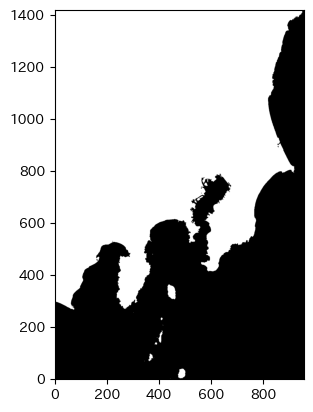

In [36]:
valid_mesh = valid_grids.reshape(lon_mesh.shape)  
plt.imshow(valid_mesh, cmap='gray', origin='lower')

In [37]:
grid_info = prepare_grid_info(df_elevation)

def convert_to_grid_indices(points: np.ndarray) -> np.ndarray:
    """座標をグリッドのインデックスに変換（高速な実装が必要）"""
    x, y = points[:, 0], points[:, 1]
    
    index_list = get_grid_xy(x, y, grid_info)

    x_index = index_list[:, 0]
    y_index = index_list[:, 1]
    
    return y_index * n_grid_x + x_index  

In [38]:
def poisson_thinning_U(
    region: Tuple[np.ndarray, np.ndarray],
    intensity_func: IntensityFunction,
    valid_grids: np.ndarray,
    volume: float
) -> Tuple[np.ndarray, np.ndarray]:
    """Poisson thinning を用いて U をサンプリング（任意の次元）"""
    # 領域の計算
    mins = np.array([region[i][0] for i in range(len(region))])
    maxs = np.array([region[i][1] for i in range(len(region))])

    # λ* × 領域の体積
    lambda_total = intensity_func.lambda_star * volume
    N = np.random.poisson(lambda_total)
    
    # validなグリッド内からN個のポイントを生成する
    candidate_points = np.empty((0, len(region)))
    while len(candidate_points) < N:
        # バッチサイズは残りの必要数
        batch_size = N - len(candidate_points)
        # 一様サンプリング
        candidates = np.random.uniform(mins, maxs, size=(batch_size, len(region)))
        
        # グリッドインデックスに変換してvalidかチェック
        grid_indices = convert_to_grid_indices(candidates)
        valid_mask = (valid_grids[grid_indices].T)[0]
        # validなものだけ追加
        if len(valid_mask) > 0: 
            candidates = candidates[valid_mask]
        candidate_points = np.vstack([candidate_points, candidates])
    
    # 正確にN個に調整
    candidate_points = np.array(candidate_points[:N])
    
    # q(x) を計算
    q_candidates = intensity_func.q(candidate_points)
    u = np.random.uniform(size=N)
    # (1 - q(x)) でフィルタリング
    U = candidate_points[u < (1 - q_candidates)]

    return U, candidate_points

In [39]:
p = len(variable_names) + 1
n = df_sites.shape[0]

X_obs = df_sites.select(["経度", "緯度"]).to_numpy().astype(np.float64)
# 存在: 1, 不在: 0
y_obs = np.ones(n)

In [40]:
def create_design_matrix(xy: np.ndarray) -> np.ndarray:
    """
    デザイン行列を作成
    
    Parameters
    ----------
    xy : np.ndarray
        座標データ（(N, 2)）
        xy[:, 0] は x座標 (x_min 以上 x_max 以下)
        xy[:, 1] は y座標 (y_min 以上 y_max 以下)
        
    Returns
    -------
    np.ndarray
        デザイン行列（(N, p+1)）
        p は説明変数の次元数
        
    Notes
    -----
    座標はグリッドに変換され、最も近いグリッドポイントの特徴量が使用されます。
    グリッドは x_min から x_max まで n_grid_x 個、
    y_min から y_max まで n_grid_y 個に均等分割されています。
    """
    
    index = convert_to_grid_indices(xy)
    
    # 切片を追加してデザイン行列を作成
    return np.column_stack([
        np.ones(len(index)),
        W_grids[index]
    ])

In [41]:
# 事前分布の設定
prior_beta_mean = np.zeros(len(variable_names) + 1)
prior_beta_cov = np.eye(len(variable_names) + 1) * 10
prior_lambda_shape = 2.0
prior_lambda_rate = 1.0

# 初期値の設定 (MCMCはかなり初期値依存性があるため、適切な初期値が重要)
beta_init = np.zeros(len(variable_names) + 1)
lambda_star_init = 30

intensity_func = IntensityFunction(create_design_matrix, beta_init, lambda_star_init)

# MCMC の実行
num_iterations = 30000
beta_samples, lambda_star_samples = mcmc_sampler(
    region=region,
    intensity_func=intensity_func,
    y_obs=y_obs,
    X_obs=X_obs,
    valid_grids=valid_grids,
    volume=volume,
    num_iterations=num_iterations,
    prior_beta_mean=prior_beta_mean,
    prior_beta_cov=prior_beta_cov,
    prior_lambda_shape=prior_lambda_shape,
    prior_lambda_rate=prior_lambda_rate
)

burn_in = 5000  
beta_samples = np.array(beta_samples)[burn_in:, :]
lambda_star_samples = np.array(lambda_star_samples)[burn_in:]

100%|██████████| 30000/30000 [00:39<00:00, 758.25it/s]


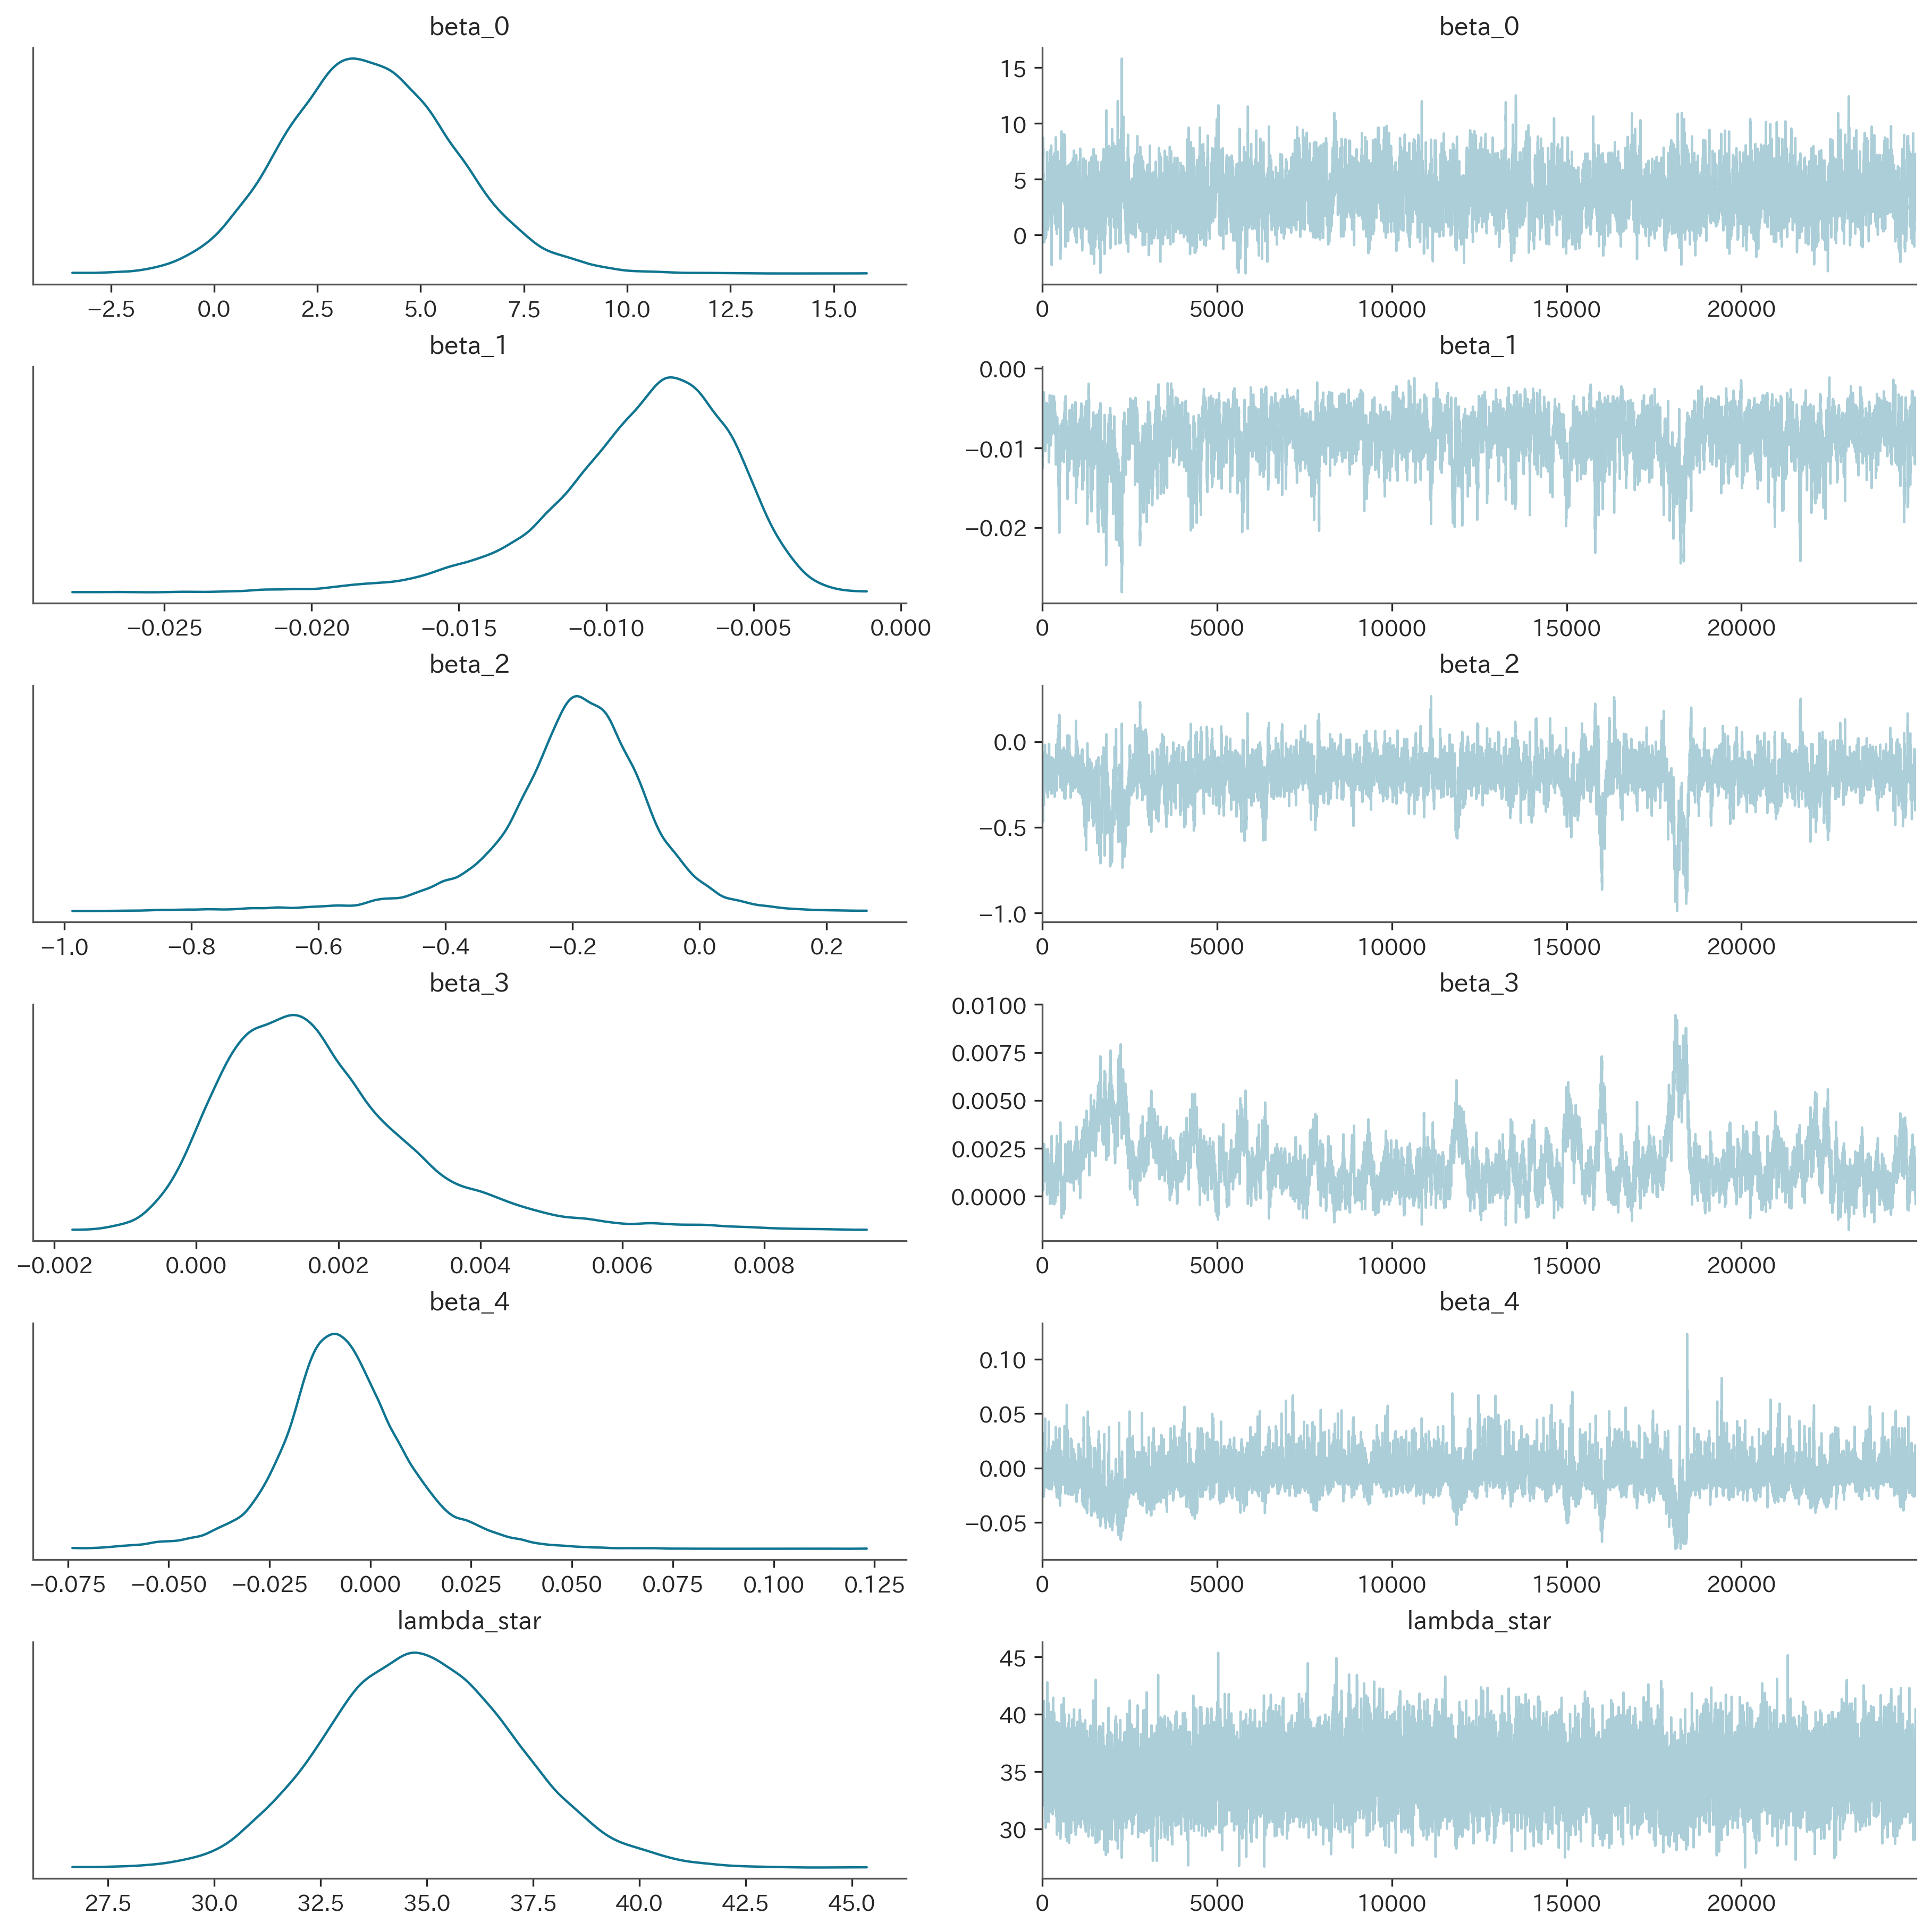

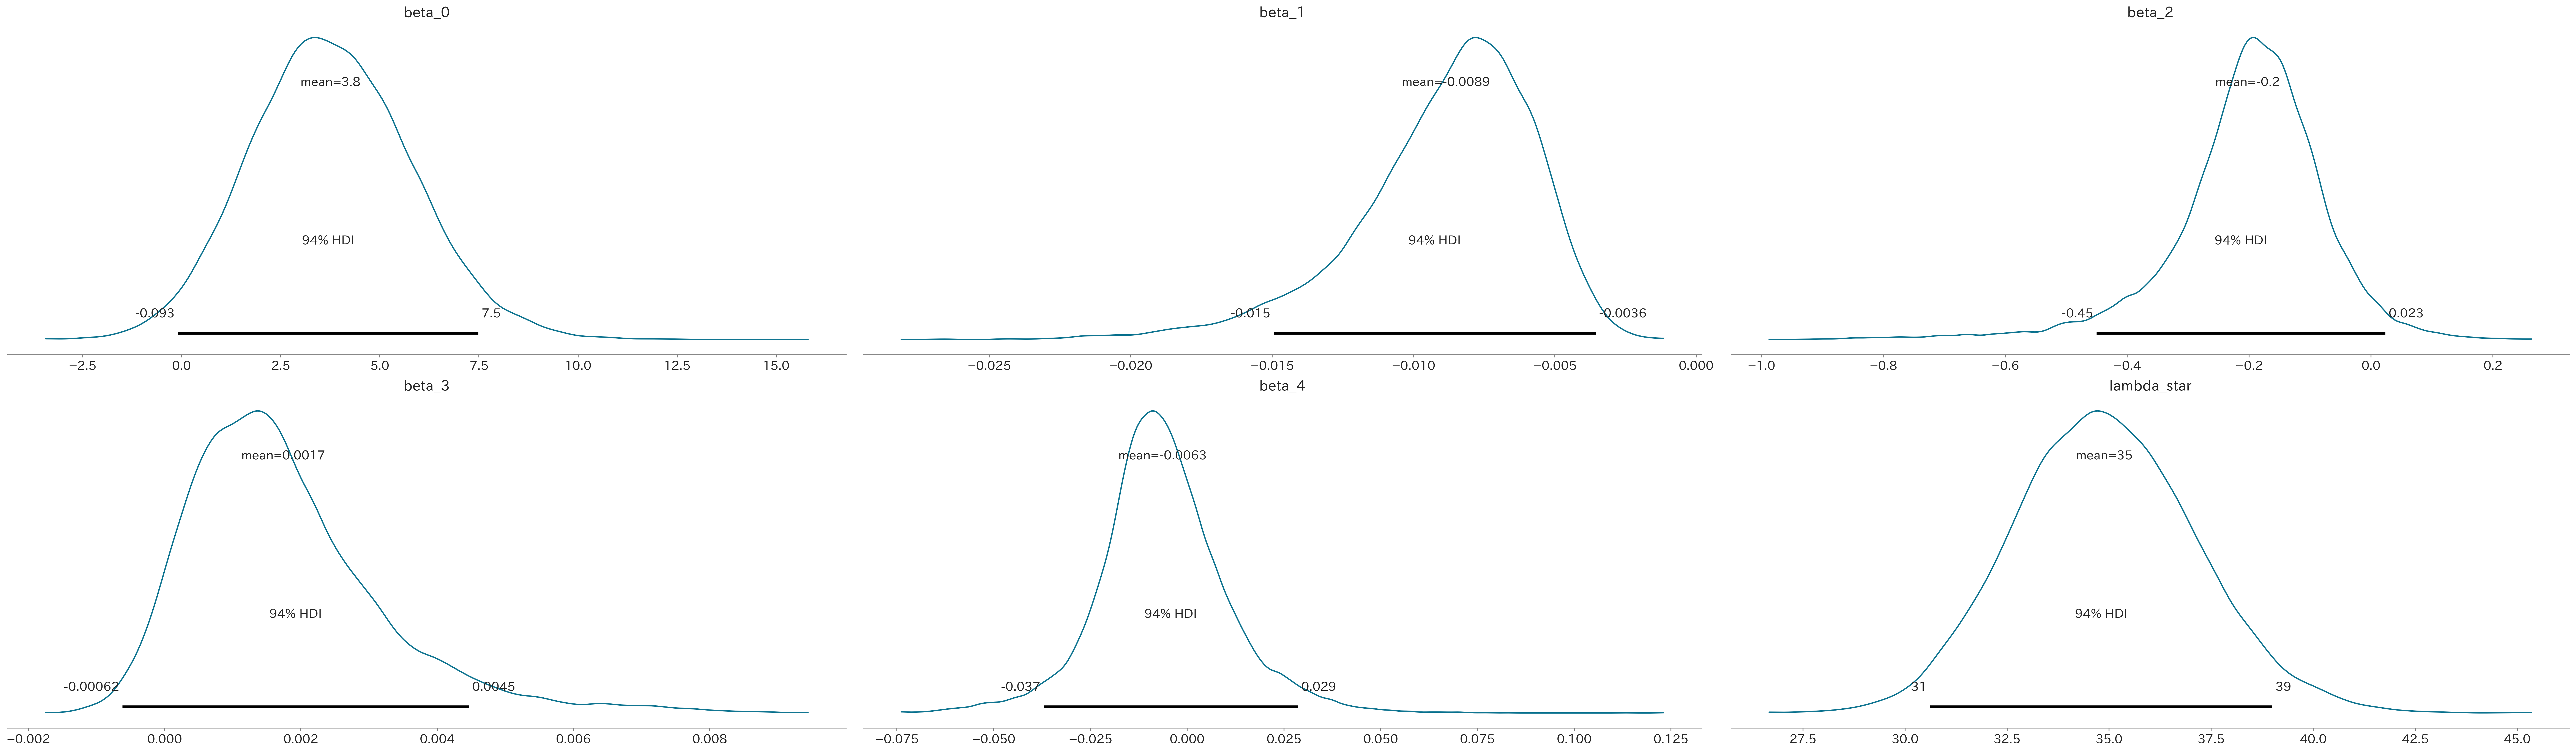

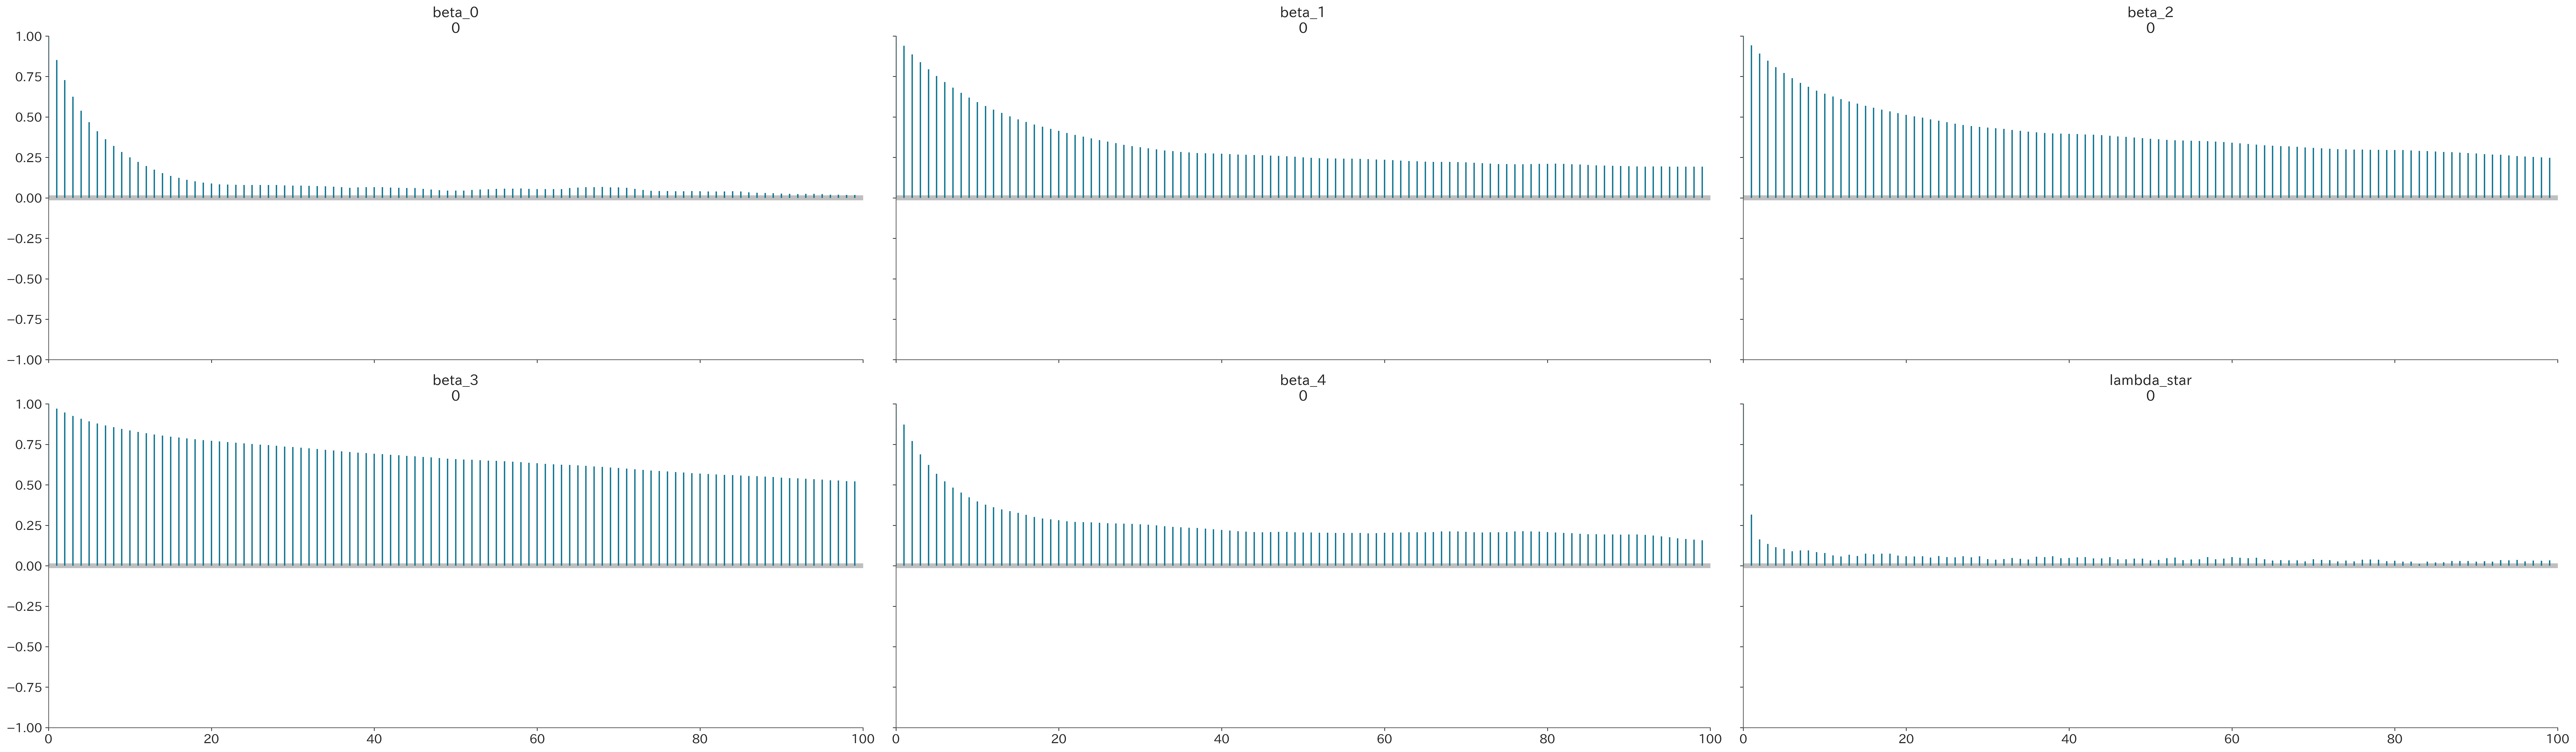

arviz - WARNING - Shape validation failed: input_shape: (1, 25000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,3.755,2.031,-0.093,7.482,0.061,0.043,1119.0,3229.0,NaN
beta_1,-0.009,0.003,-0.015,-0.004,0.000,0.000,228.0,404.0,NaN
beta_2,-0.203,0.127,-0.450,0.023,0.010,0.009,224.0,126.0,NaN
beta_3,0.002,0.001,-0.001,0.004,0.000,0.000,65.0,82.0,NaN
beta_4,-0.006,0.017,-0.037,0.029,0.001,0.001,170.0,111.0,NaN
lambda_star,34.879,2.247,30.614,38.994,0.055,0.039,1666.0,10606.0,NaN


In [42]:
import arviz as az

# サンプル数とパラメータ数の取得
num_samples, num_beta = beta_samples.shape

# パラメータ名とサンプルの辞書を作成
posterior_samples = {}

# βの各成分を辞書に追加
for i in range(num_beta):
    param_name = f'beta_{i}'
    posterior_samples[param_name] = beta_samples[:, i]

# λ*を辞書に追加
posterior_samples['lambda_star'] = lambda_star_samples

# InferenceDataオブジェクトを作成
idata = az.from_dict(posterior=posterior_samples)

# --- ArviZによる可視化と解析 ---
az.style.use("arviz-doc")


# トレースプロット
az.plot_trace(idata)
plt.show()

# 事後分布のプロット
az.plot_posterior(idata)
plt.show()

# 自己相関プロット
az.plot_autocorr(idata)
plt.show()

# 統計的な概要情報の表示
summary_df = az.summary(idata)
display(summary_df)

# スタイルをリセット
az.style.use("default")


In [43]:
"""
plot_intensity_posterior_2d(
    region=region,
    beta_samples=np.array(beta_samples),
    lambda_star_samples=np.array(lambda_star_samples),
    intensity_func=intensity_func.copy(),
    num_points=100,
    credible_interval=0.95,
    events=X_obs[y_obs == 1], 
    cmap='Blues',
)
"""

"\nplot_intensity_posterior_2d(\n    region=region,\n    beta_samples=np.array(beta_samples),\n    lambda_star_samples=np.array(lambda_star_samples),\n    intensity_func=intensity_func.copy(),\n    num_points=100,\n    credible_interval=0.95,\n    events=X_obs[y_obs == 1], \n    cmap='Blues',\n)\n"

In [44]:
intensity_func.update_beta(beta_samples.mean(axis=0))
intensity_func.update_lambda_star(lambda_star_samples.mean())

X_grids = grid_coords / np.pi * 180
X_grids = X_grids[:, [1, 0]]

df_elevation = (
    df_elevation
    .with_columns(
        pl.Series("site_probability", intensity_func.q(X_grids))
    )
)

/tmp/ipykernel_1602064/2387361062.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(
/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32239 (\N{CJK UNIFIED IDEOGRAPH-7DEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36986 (\N{CJK UNIFIED IDEOGRAPH-907A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36321 (\N{CJK UNIFIED 

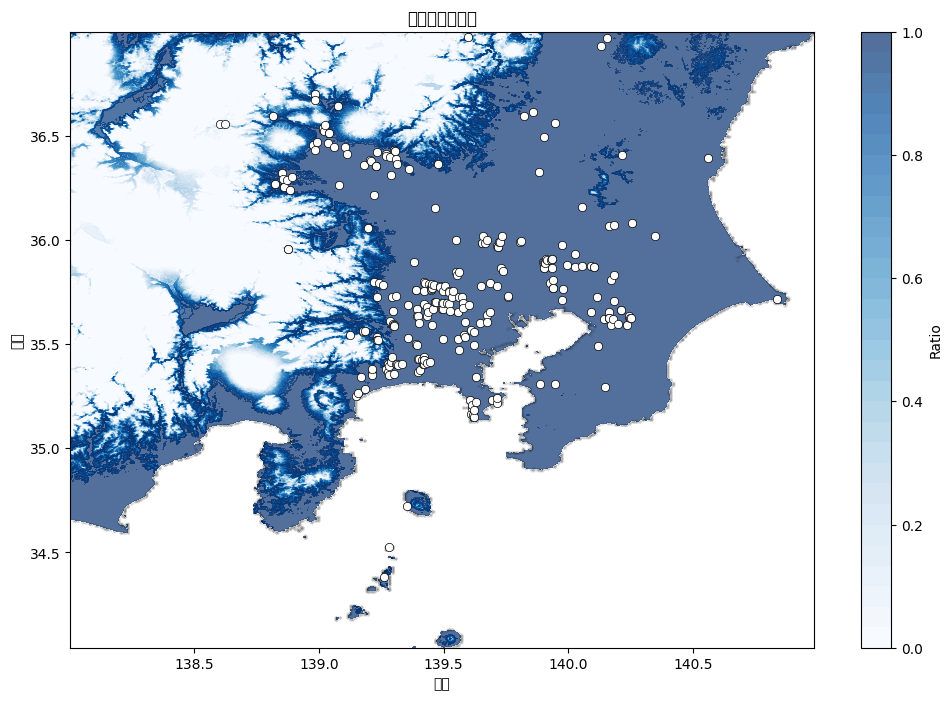

In [45]:
import japanize_matplotlib
fig, ax = plot_contour(df_elevation, value_col=f"site_probability", plot_probability=True)

boundary_df = df_elevation.filter(pl.col("is_sea") == 0, pl.col("average_elevation").is_null())

ax.scatter(
    boundary_df["x"], 
    boundary_df["y"], 
    c="black", 
    s=0.001
)

ax.scatter(
    df_sites["経度"], 
    df_sites["緯度"], 
    c="white", 
    edgecolors="black", 
    linewidths=0.5,
    vmin=0,
    vmax=1 
)

ax.set_title(f"遺跡の存在確率")
plt.show()

In [46]:
df_elevation.write_csv(os.path.join(data_dir, "16_gdf_elevation_with_ratio.csv"))
df_sites.write_csv(os.path.join(data_dir, "16_gdf_sites_with_ratio.csv"))